Cross Time Sampling
===

Sampling from April 2014 (start of the training data period) to December 2019.

A sample is generated for each month. (n=50000)

Each sample is saved in a mock json file to be used for `revscoring extract`.

Then, `revscoring extract` and `revscoring dump` are used to generate TSV feature files for each of the samples.

Note that each section of this notebook is designed to be run independently, with no dependencies from other sections other than this intro section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [4]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [5]:
working_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [6]:
start_date = datetime.fromisoformat('2014-04-01')
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01')
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1396328400, 1577858400)

### Load in all revisions

This is a 31GB text file!

We load it in, before sorting and filtering it and saving it back to a more efficient format.  

In [7]:
start = datetime.now()
rev_ids_filepath = os.path.join(working_dir, 'rev_ids_2010to2019.csv')
df = pd.read_csv(rev_ids_filepath,
                 header=None, 
                 names=['page_id', 'namespace', 'is_redirect', 'rev_id', 'rev_timestamp', 'user_text', 'user_id', 'is_revert_target', 'is_reverted', 'is_reverting'],
                 usecols=['namespace', 'rev_id', 'rev_timestamp']
)
print(f"{datetime.now() - start}")
len(df)

0:05:15.649614


560488708

In [8]:
start = datetime.now()
df = df.sort_values(by='rev_timestamp')
print(f"{datetime.now() - start}")

0:03:58.842091


In [9]:
total_revisions = len(df)
df = df[(df.rev_timestamp >= start_timestamp)&(df.rev_timestamp <= end_timestamp)]
revisions_in_sample_period = len(df)
print(f"{revisions_in_sample_period} / {total_revisions} ({revisions_in_sample_period / total_revisions * 100:.2f}%) revisions in the sample period.")

314294776 / 560488708 (56.08%) revisions in the sample period.


In [10]:
ns_counts = Counter(df.namespace).most_common()

In [15]:
for ns, count in ns_counts:
    print(f"{ns:>5} {count:>14,}")

    0    223,764,027
    3     21,989,780
    1     18,260,935
    2     17,737,950
    4     15,472,242
   10      4,775,639
   14      3,977,104
    6      2,351,682
   15      1,738,138
    5      1,517,715
  118        721,013
   11        578,468
  100        384,856
    7        364,262
  109        259,794
  828        148,056
  119         44,275
   13         41,234
   12         38,142
  101         29,895
  829         25,671
    9         25,069
  108         24,683
    8         10,770
  447          9,176
  710          4,136
  711             49
 2301             13
 2300              2


In [16]:
# save the dataframe as a pickle file
start = datetime.now()
revisions_filepath = os.path.join(working_dir, 'rev_ids_2014to2019.pkl')
df.to_pickle(revisions_filepath)
print(f"{datetime.now() - start}")
print("Finished.")

0:00:44.654797
Finished.


In [28]:
# save the dataframe as a csv file
start = datetime.now()
revisions_filepath = os.path.join(working_dir, 'rev_ids_2014to2019_sorted.csv')
df.to_csv(revisions_filepath, index=False)
print(f"{datetime.now() - start}")
print("Finished.")

0:34:38.085038
Finished.


### Process the data to generate the samples

In [7]:
# read the dataframe with the revision ids and timestamps
start = datetime.now()
revisions_filepath = os.path.join(working_dir, 'rev_ids_2014to2019.pkl')
df = pd.read_pickle(revisions_filepath)
print(f"{datetime.now() - start}")
len(df)

0:00:09.353400


314294776

In [17]:
df.head()

,namespace,rev_id,rev_timestamp
485660333,0,602188145,1396328400
485660289,0,602188144,1396328400
227824978,2,602188150,1396328401
91408863,0,602188147,1396328401
386763115,4,602188148,1396328401


In [18]:
def get_month_ids(arr):
    result = np.zeros(len(arr), dtype=int)
    for i, rev_timestamp in enumerate(arr):
        result[i] = int(datetime.utcfromtimestamp(rev_timestamp).strftime('%Y%m'))
    return result
from multiprocessing import Pool
with Pool(processes=32) as pool:
    arrs = np.array_split(df.rev_timestamp.to_numpy(), int(len(df) / 1000000))
    multiple_results = [pool.apply_async(get_month_ids, kwds={'arr': arr}) for arr in arrs]
    result_arrs = []
    for result in tqdm(multiple_results, total=len(arrs)):
        result_arrs.append(result.get())

100%|██████████| 314/314 [02:05<00:00,  2.50it/s]


In [19]:
df['month_id'] = np.concatenate(result_arrs)

In [20]:
month_ids_in_sample = set(df.month_id)
len(month_ids_in_sample)

70

In [21]:
# the first month in the sample (April 2014) has approximately 4 million revisions
len(df[df.month_id == 201404])

4030062

In [22]:
month_sample_n = 20000
for month_id, group in tqdm(df.groupby(by='month_id'), total=len(month_ids_in_sample)):
    month_id_str = str(month_id)
    year = month_id_str[:4]
    month = month_id_str[4:]
    if len(group) < 1000000:
        print(f"Not sampling for month {month}/{year}, which only has {len(group)} revisions.")
        continue
    month_sample = group.sample(n=month_sample_n)
    sample_rev_ids_filepath = os.path.join(working_dir, f"month_sample/rev_ids/rev_ids_month_sample_{year}_{month}.txt")
    with open(sample_rev_ids_filepath, 'w') as outfile:
        for rev_id in month_sample.rev_id:
            outfile.write(str(rev_id) + "\n")

100%|██████████| 70/70 [00:34<00:00,  2.05it/s]

Not sampling for month 01/2020, which only has 42381 revisions.


In [39]:
xtick_labels = []
month_revisions_list = []
for month_id, group in tqdm(df.groupby(by='month_id'), total=len(month_ids_in_sample)):
    month_id_str = str(month_id)
    year = month_id_str[:4]
    month = month_id_str[4:]
    if year == "2020":
        continue
    xtick_labels.append(f"{month}/{year[2:]}")
    month_revisions_list.append(len(group))

100%|██████████| 70/70 [00:17<00:00,  3.98it/s]


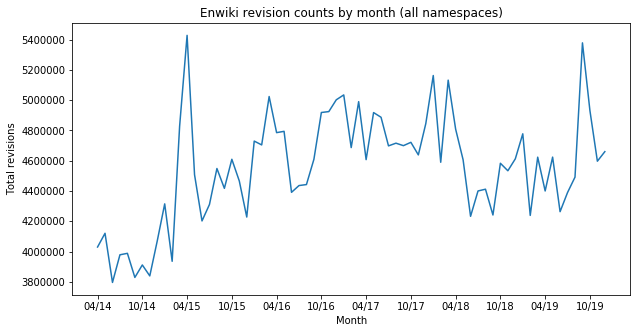

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plt.plot(range(len(month_revisions_list)), month_revisions_list)
plt.xticks(range(0, len(month_revisions_list), 6), xtick_labels[::6])
plt.title("Enwiki revision counts by month (all namespaces)")
plt.xlabel("Month")
plt.ylabel("Total revisions")
plt.show()

In [44]:
namespaces = [0, 1, 2, 3, 4, 5, 6, 10, 14, 15]
month_revisions_list = np.zeros((len(month_ids_in_sample)-1, len(namespaces)))
i = 0
for month_id, group in tqdm(df.groupby(by='month_id'), total=len(month_ids_in_sample)):
    if month_id == 202001:
        continue
    for j, ns in enumerate(namespaces):
        month_revisions_list[i, j] = np.sum(group.namespace == ns)
    i += 1

100%|██████████| 70/70 [00:25<00:00,  2.76it/s]


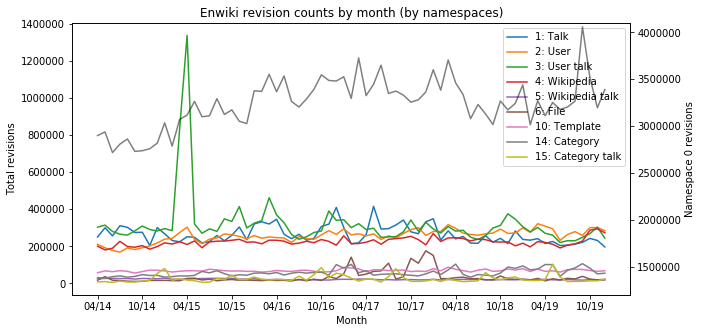

In [68]:
namespace_name_map = {
    0: "Main/Article",
    1: "Talk",
    2: "User",
    3: "User talk",
    4: "Wikipedia",
    5: "Wikipedia talk",
    6: "File",
    10: "Template",
    14: "Category",
    15: "Category talk",
}

fig, ax = plt.subplots(1, 1, figsize=(10,5))
plt.xticks(range(0, n_months, 6), xtick_labels[::6])
n_months = len(month_ids_in_sample) - 1
for j, ns in enumerate(namespaces):
    if ns == 0:
        ax2 = ax.twinx()
        ax2.plot(range(n_months), month_revisions_list[:,j], label=f"{ns}: {namespace_name_map[ns]}", color='black', alpha=0.5)
        ax2.set_ylabel("Namespace 0 revisions")
        ax2.set_ylim((1200000,4100000))
        continue
    ax.plot(range(n_months), month_revisions_list[:,j], label=f"{ns}: {namespace_name_map[ns]}")

ax.set_title("Enwiki revision counts by month (by namespaces)")
ax.set_xlabel("Month")
ax.set_ylabel("Total revisions")
ax.legend()
plt.show()

In [56]:
# let's investigate the spike of User Talk revisions
ut_df = df[df.namespace == 3]
len(ut_df)

21989780

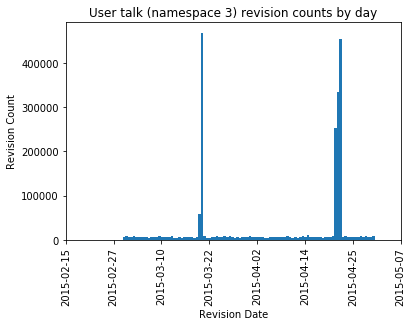

In [66]:
ut_start_timestamp = int(datetime.fromisoformat('2015-03-01').timestamp())
ut_end_timestamp = int(datetime.fromisoformat('2015-05-01').timestamp())

ut_df_subset = ut_df[(ut_df.rev_timestamp >= ut_start_timestamp)&(ut_df.rev_timestamp <= ut_end_timestamp)]
plt.hist(ut_df_subset.rev_timestamp, bins=100)

xticks, _ = plt.xticks()
plt.xticks(xticks, 
           [datetime.utcfromtimestamp(xtick).strftime("%Y-%m-%d") for xtick in xticks], 
           rotation='vertical')
plt.title("User talk (namespace 3) revision counts by day")
plt.xlabel("Revision Date")
plt.ylabel("Revision Count")
plt.show()

In [64]:
days = [int(datetime.utcfromtimestamp(rt).strftime("%Y%m%d")) for rt in ut_df_subset.rev_timestamp]
mc = Counter(days)
mc.most_common(10)

[(20150422, 747373),
 (20150320, 526597),
 (20150421, 208592),
 (20150423, 100172),
 (20150415, 12906),
 (20150428, 12688),
 (20150401, 12636),
 (20150414, 12628),
 (20150327, 12584),
 (20150306, 12149)]

In [65]:
mc[20150319], mc[20150320], mc[20150321]

(10785, 526597, 9789)

### Generate mock JSON

Generate mock JSON for use with `revscoring` and generate the appropriate revscoring bash script.


In [25]:
# now generate mock JSON for month samples
rev_ids_dir = os.path.join(working_dir, 'month_sample/rev_ids')
mock_json_dir = os.path.join(working_dir, 'month_sample/mock_json')
revscoring_scripts_dir = os.path.join(working_dir, 'month_sample/revscoring_scripts')
revscoring_cache_dir = os.path.join(working_dir, 'month_sample/revscoring_cache')
revscoring_features_dir = os.path.join(working_dir, 'month_sample/revscoring_features')
os.makedirs(mock_json_dir, exist_ok=True)
os.makedirs(revscoring_scripts_dir, exist_ok=True)
os.makedirs(revscoring_cache_dir, exist_ok=True)
os.makedirs(revscoring_features_dir, exist_ok=True)

mock_template = '{"rev_id": %d, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}'
script_template = """#!/bin/bash
# Auto-generated script to use revscoring to extract features for a set of revisions

if [ -f {revscoring_features_filepath} ]; then
    echo "Skipping '$(basename {mock_json_filepath})' with existing features file."
else
    cat {mock_json_filepath} | revscoring extract editquality.feature_lists.enwiki.damaging editquality.feature_lists.enwiki.goodfaith --host https://en.wikipedia.org --extractors 32 --verbose > {revscoring_cache_filepath} \\
        || (echo "Failed to build feature caches" && exit 1)
    revscoring dump_cache --input {revscoring_cache_filepath} --output {revscoring_features_filepath} editquality.feature_lists.enwiki.damaging damaging \\
        || (echo "Failed to dump cache" && exit 1)
    echo "Successfully extracted '$(basename {mock_json_filepath})'."
fi
"""

revscoring_script_filepaths = []
for filename in tqdm(os.listdir(rev_ids_dir), total=69):
    if not filename.endswith(".txt"):
        continue
    rev_ids_filepath = os.path.join(rev_ids_dir, filename)
    rev_ids_list = []
    with open(rev_ids_filepath) as infile:
        for line in infile:
            if line.strip() != "":
                rev_ids_list.append(int(line.strip()))
    fname_base = os.path.splitext(filename)[0]
    mock_json_filepath = os.path.join(mock_json_dir, fname_base + ".mock.json")
    revscoring_script_filepath = os.path.join(revscoring_scripts_dir, fname_base + '_revscoring.sh')
    revscoring_cache_filepath = os.path.join(revscoring_cache_dir, fname_base + ".mock.w_cache.json")
    revscoring_features_filepath = os.path.join(revscoring_features_dir, fname_base + ".mock.damaging.tsv")
    with open(mock_json_filepath, 'w') as outfile:
        for rev_id in rev_ids_list:
            line = mock_template % rev_id
            outfile.write(line + "\n")
    
    script_text = script_template.format(
        mock_json_filepath=mock_json_filepath,
        revscoring_cache_filepath=revscoring_cache_filepath,
        revscoring_features_filepath=revscoring_features_filepath
    )
    with open(revscoring_script_filepath, 'w') as outfile:
        outfile.write(script_text)
    revscoring_script_filepaths.append(revscoring_script_filepath)

100%|██████████| 69/69 [00:02<00:00, 27.50it/s]


In [31]:
revscoring_all_script_base = """#!/bin/bash
# Auto-generated script that calls the sub-scripts to extract features for all month samples
# The 'wiki-revscoring' conda environment needs to be active

cd /export/scratch2/levon003/repos/revscoring
"""

revscoring_all_script = revscoring_all_script_base
for i, revscoring_script_filepath in enumerate(revscoring_script_filepaths):
    if i != 0:
        revscoring_all_script += " && "
    revscoring_all_script += revscoring_script_filepath + " \\ \n"
revscoring_all_script += '&& echo "Success." && exit 0\n'
revscoring_all_script += 'echo "Failure." && exit 1\n'
revscoring_all_script_filepath = os.path.join(working_dir, "month_sample/revscoring_extract_all.sh")
with open(revscoring_all_script_filepath, 'w') as outfile:
    outfile.write(revscoring_all_script)
print("Finished.")

Finished.


In [32]:
print(revscoring_all_script)

#!/bin/bash
# Auto-generated script that calls the sub-scripts to extract features for all month samples
# The 'wiki-revscoring' conda environment needs to be active

cd /export/scratch2/levon003/repos/revscoring
/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2019_03_revscoring.sh \ 
 && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2015_07_revscoring.sh \ 
 && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2018_05_revscoring.sh \ 
 && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2017_06_revscoring.sh \ 
 && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/mont

In [34]:
single_command = " && ".join(sorted(revscoring_script_filepaths))
single_command += ' && echo "Success." && exit 0'
print(single_command)

/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2014_04_revscoring.sh && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2014_05_revscoring.sh && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2014_06_revscoring.sh && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2014_07_revscoring.sh && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2014_08_revscoring.sh && /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_scripts/rev_ids_month_sample_2014_09_rev

Then, the permissions on all of these scripts should be manually set.

i.e. `chmod +x *.sh`